In [1]:
import pandas as pd
import nltk 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
nltk.download("stopwords")
from nltk.corpus import stopwords
import re
import os
import string 
from sklearn.model_selection import GridSearchCV
from nltk.corpus import wordnet
import string

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


## Загрузка данных

Используем датасет твитов https://huggingface.co/datasets/zeroshot/twitter-financial-news-topic

In [2]:
df = pd.read_csv("topic_train.csv")
df

,text,label
0,Here are Thursday's biggest analyst calls: App...,0
1,Buy Las Vegas Sands as travel to Singapore bui...,0
2,"Piper Sandler downgrades DocuSign to sell, cit...",0
3,"Analysts react to Tesla's latest earnings, bre...",0
4,Netflix and its peers are set for a ‘return to...,0
...,...,...
16985,KfW credit line for Uniper could be raised to ...,3
16986,KfW credit line for Uniper could be raised to ...,3
16987,Russian https://t.co/R0iPhyo5p7 sells 1 bln r...,3
16988,Global ESG bond issuance posts H1 dip as supra...,3


Здесь представлен список топиков:

In [3]:
topics = {
    0: "Analyst Update",
    1: "Fed | Central Banks",
    2: "Company | Product News",
    3: "Treasuries | Corporate Debt",
    4: "Dividend",
    5: "Earnings",
    6: "Energy | Oil",
    7: "Financials",
    8: "Currencies",
    9: "General News | Opinion",
    10: "Gold | Metals | Materials",
    11: "IPO",
    12: "Legal | Regulation",
    13: "M&A | Investments",
    14: "Macro",
    15: "Markets",
    16: "Politics",
    17: "Personnel Change",
    18: "Stock Commentary",
    19: "Stock Movement",
}

In [4]:
df["label_name"] = df["label"].apply(lambda x: topics[x])
df

,text,label,label_name
0,Here are Thursday's biggest analyst calls: App...,0,Analyst Update
1,Buy Las Vegas Sands as travel to Singapore bui...,0,Analyst Update
2,"Piper Sandler downgrades DocuSign to sell, cit...",0,Analyst Update
3,"Analysts react to Tesla's latest earnings, bre...",0,Analyst Update
4,Netflix and its peers are set for a ‘return to...,0,Analyst Update
...,...,...,...
16985,KfW credit line for Uniper could be raised to ...,3,Treasuries | Corporate Debt
16986,KfW credit line for Uniper could be raised to ...,3,Treasuries | Corporate Debt
16987,Russian https://t.co/R0iPhyo5p7 sells 1 bln r...,3,Treasuries | Corporate Debt
16988,Global ESG bond issuance posts H1 dip as supra...,3,Treasuries | Corporate Debt


Рассмотрим сколько сообщений на каждый топик в датасете

Text(0.5, 1.0, 'количество статей по темам')

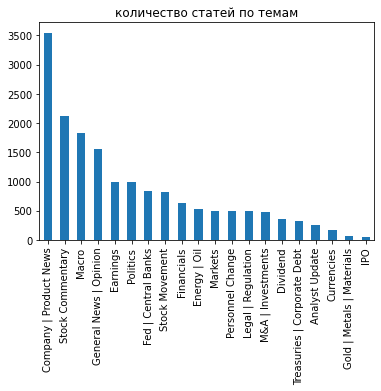

In [5]:
df.label_name.value_counts().plot.bar()
plt.title("количество статей по темам")

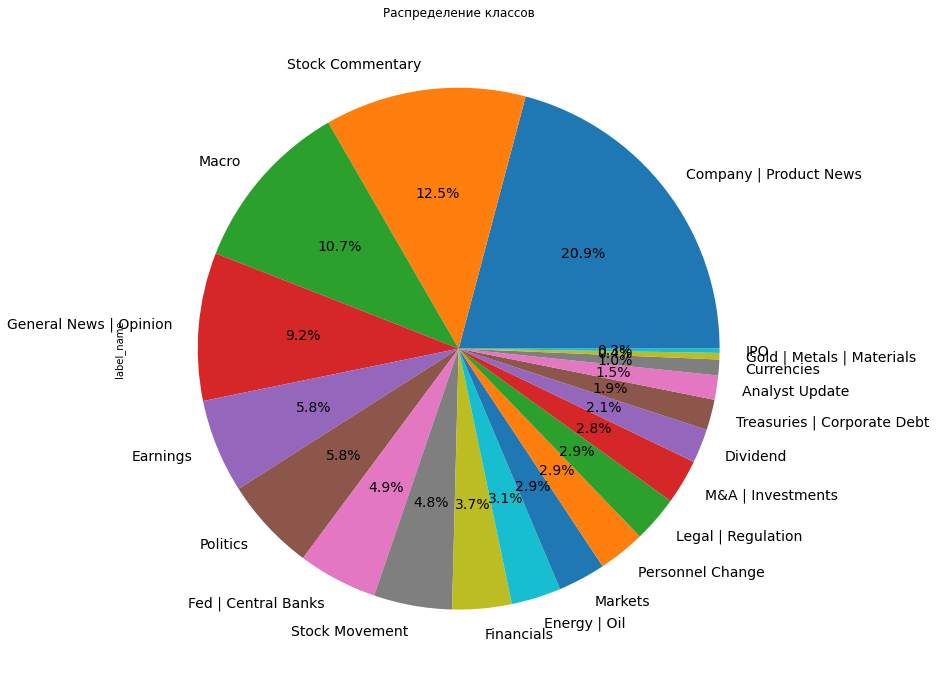

In [6]:
plt.figure(figsize=(12, 12))
df.label_name.value_counts().plot.pie( autopct='%1.1f%%', textprops={'fontsize': 14})
plt.yticks()
plt.title("Распределение классов")
plt.show()

И наконец посмотрим на гистограмму распределения длины твита

Text(0.5, 1.0, 'Длина твитов')

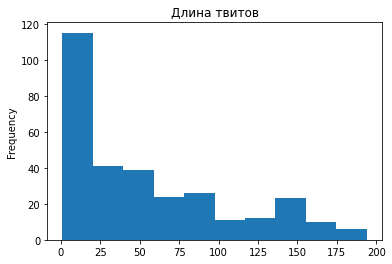

In [7]:
df["len"] = df["text"].apply(lambda c: len(c))
df.len.value_counts().plot.hist()
plt.title("Длина твитов")

## Препроцессинг

Из препроцессинга важно убрать ссылки на тг каналы и лишние символы пунктуации. Далее мы приводим к нормальной форме с помощью лемматизации Lemmatize из WordNet

In [8]:
import string 
stops = stopwords.words('english')
punct = string.punctuation + "`'‘’"
lemmatizer = WordNetLemmatizer()
nltk.download("wordnet")
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def text_process(input: str) -> str:
  output = input.lower()
  output = re.sub(r"\S*@\S*\s?", "", input) #emails
  output = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', output) # any URL
  output = re.sub(r'[.,!()?:<>#]{2,}', '', output) # repeated punctuations
  output = re.sub(r'\s{2,}', ' ', output) # repeated spaces
  output = [t for t in output if t not in punct]
  output = "".join(output)
  pos_tagged_text = nltk.pos_tag(output.split(" "))
  lems =  [lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text]
  output = [token for token in output if token not in stops]
  return lems

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [9]:
def pipeline(input):
  output = text_process(input)

  return " ".join(output)

df["text_processed"] = df["text"].apply(pipeline)

In [10]:
df

,text,label,label_name,len,text_processed
0,Here are Thursday's biggest analyst calls: App...,0,Analyst Update,126,Here be Thursdays big analyst call Apple Amazo...
1,Buy Las Vegas Sands as travel to Singapore bui...,0,Analyst Update,92,Buy Las Vegas Sands a travel to Singapore buil...
2,"Piper Sandler downgrades DocuSign to sell, cit...",0,Analyst Update,109,Piper Sandler downgrade DocuSign to sell cite ...
3,"Analysts react to Tesla's latest earnings, bre...",0,Analyst Update,113,Analysts react to Teslas late earnings break d...
4,Netflix and its peers are set for a ‘return to...,0,Analyst Update,123,Netflix and it peer be set for a return to gro...
...,...,...,...,...,...
16985,KfW credit line for Uniper could be raised to ...,3,Treasuries | Corporate Debt,120,KfW credit line for Uniper could be raise to 8...
16986,KfW credit line for Uniper could be raised to ...,3,Treasuries | Corporate Debt,120,KfW credit line for Uniper could be raise to 8...
16987,Russian https://t.co/R0iPhyo5p7 sells 1 bln r...,3,Treasuries | Corporate Debt,127,Russian sell 1 bln rouble at oneyear repo auct...
16988,Global ESG bond issuance posts H1 dip as supra...,3,Treasuries | Corporate Debt,114,Global ESG bond issuance post H1 dip a suprana...


In [11]:
df.to_csv("topic_train_processed.csv")

## Exploratory analysis

Рассмотрим график распределения частот слов чтобы выделить основные слова

In [12]:
from collections import Counter
words_count = Counter()

def tfs(xs):
    global words_count
    for tks in xs.split(" "):  
        words_count[tks]+=1

df.text_processed.map(lambda x: tfs(x))
del words_count[""]

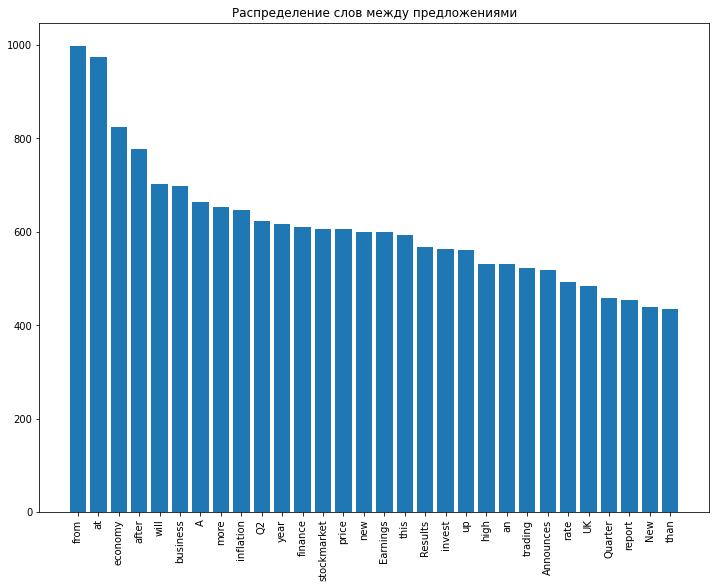

In [13]:
vals = [[i, words_count[i]] for i in words_count]
vals = sorted(vals, key=lambda x: x[1], reverse=True)
x = [i[0] for i in vals[20:50]]
y = [i[1] for i in vals[20:50]]
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 9))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title("Распределение слов между предложениями")
plt.show()

Сравним пару классов - построим частоты для слов, входящих в тексты разных классов

In [14]:
from collections import Counter
words_count = Counter()

def tfs(xs):
    global words_count
    for tks in xs.split(" "):  
        words_count[tks]+=1

df[df["label"]==6]["text_processed"].map(lambda x: tfs(x))
del words_count[""]


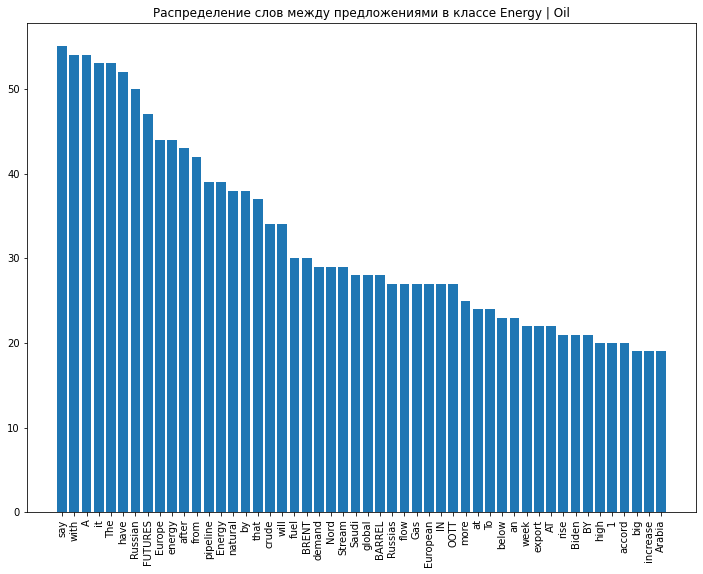

In [15]:
vals = [[i, words_count[i]] for i in words_count]
vals = sorted(vals, key=lambda x: x[1], reverse=True)
x = [i[0] for i in vals[20:70]]
y = [i[1] for i in vals[20:70]]
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 9))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title(f"Распределение слов между предложениями в классе { topics[6]}")
plt.show()

In [16]:
from collections import Counter
words_count = Counter()

def tfs(xs):
    global words_count
    for tks in xs.split(" "):  
        words_count[tks]+=1

df[df["label"]==2]["text_processed"].map(lambda x: tfs(x))
del words_count[""]

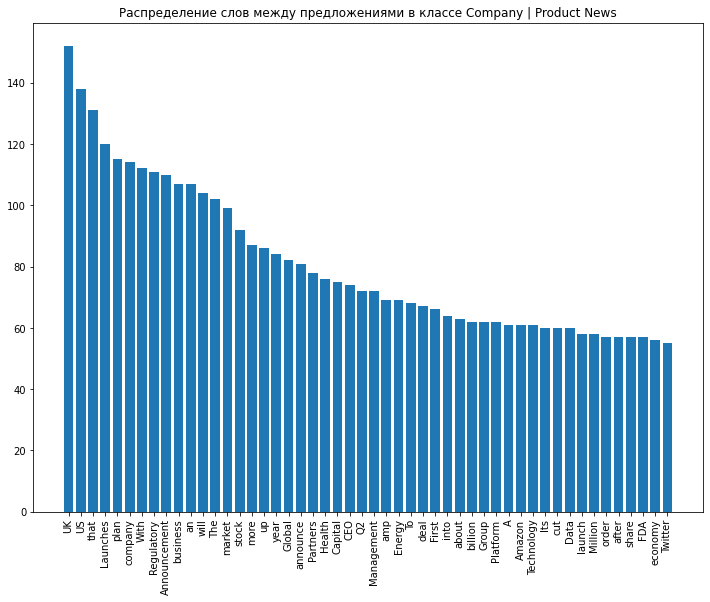

In [17]:
vals = [[i, words_count[i]] for i in words_count]
vals = sorted(vals, key=lambda x: x[1], reverse=True)
x = [i[0] for i in vals[20:70]]
y = [i[1] for i in vals[20:70]]
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 9))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title(f"Распределение слов между предложениями в классе { topics[2]}")
plt.show()

## Bow и TFIdf

Попробуем базовый метод векторонго представления - мешок слов

In [19]:
bow_vectorization = None
y = df["label"].to_numpy() 
X = CountVectorizer().fit_transform(df["text_processed"])
bow_vectorization = X
bow_vectorization.shape

(16990, 24178)

С исходными настройками получаем вектор размером 21914, попробуем снизить размерность с помощью ограничения длины. Попробуе разные варианты, а также попробуем поработать с би-граммами

In [20]:
vectorization = {}
vectorization["BoW"] = {}
bow_vectorization = vectorization["BoW"]
max_feature_variants = [500, 1000, 5000, 10000]
for size_vector in max_feature_variants:
    X = CountVectorizer(max_features=size_vector).fit_transform(df["text_processed"])
    bow_vectorization[size_vector] = X

In [21]:
vectorization["BoW_ngrams"] = {}
bow_vectorization_ngrams = vectorization["BoW_ngrams"]
for size_vector in max_feature_variants:
    X = CountVectorizer(ngram_range=(2, 2), max_features=size_vector).fit_transform(df["text_processed"])
    bow_vectorization_ngrams[size_vector] = X

И то же самое продделаем с TF-IDF

In [22]:
vectorization["TfIdf"] = {}
tfidf_vectorization = vectorization["TfIdf"] 
for size_vector in max_feature_variants:
    X = TfidfVectorizer(max_features=size_vector).fit_transform(df["text_processed"])
    tfidf_vectorization[size_vector] = X

In [23]:
vectorization["TfIdf_ngrams"] = {}
tfidf_vectorization_ngrams = vectorization["TfIdf_ngrams"]
for size_vector in max_feature_variants:
    X = TfidfVectorizer(ngram_range=(2, 2), max_features=size_vector).fit_transform(df["text_processed"])
    tfidf_vectorization_ngrams[size_vector] = X

И определим функцию проверки модели, которая для каждого класса будет возвращать метрики точности

In [24]:
def validate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return classification_report(y_test, y_pred, target_names=list(topics.values()), output_dict=True)

В качестве моделей МО я решил использовать классификаторы RandomForest и SVM. Переберем различные варианты и посмотрим на результат

In [ ]:
def train_models(X, y):
    results = {"RFC":[], "SVC":[]}
    model_rfc = RandomForestClassifier()
    model_svc = SVC()
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    print(" - Model - RandomForest")
    model_rfc.fit(X_train, y_train)
    print(" - Model - SVM")
    model_svc.fit(X_train, y_train)
    results["RFC"] = validate_model(model_rfc, X_test, y_test)
    results["SVC"] = validate_model(model_svc, X_test, y_test)
    return results


overall_results = {}
for embedding in vectorization:
    overall_results[embedding] = {}
    for max_feature_num in vectorization[embedding]:
        X = vectorization[embedding][max_feature_num]
        print("Vectorization:", embedding, "Features: ", max_feature_num)
        overall_results[embedding][max_feature_num] = train_models(X, y)

In [26]:
import pickle 
if (not os.path.exists("simple_methods")):
    pickle.dump(overall_results, open("simple_methods", "bw"))
else:
    overall_results = pickle.load(open("simple_methods", "br"))

In [27]:
tf_overall_results = pickle.load(open("simple_methods", "br"))
x = [[i, j, m, tf_overall_results[i][j][m]["accuracy"]] for i in tf_overall_results for j in tf_overall_results[i] for m in tf_overall_results[i][j]]
mdf = pd.DataFrame(x)
mdf.to_csv("bow_tfidf.csv")
mdf.sort_values(3, ascending=False)

,0,1,2,3
21,TfIdf,5000,SVC,0.801554
19,TfIdf,1000,SVC,0.793785
23,TfIdf,10000,SVC,0.782957
7,BoW,10000,SVC,0.773070
5,BoW,5000,SVC,0.769068
17,TfIdf,500,SVC,0.756356
6,BoW,10000,RFC,0.754473
20,TfIdf,5000,RFC,0.752354
4,BoW,5000,RFC,0.748352
3,BoW,1000,SVC,0.746469


По метрике средней точности би-граммы дают слабее результат. Лучшие результаты показали:
SVM на Tf-Idf и Bow, (0.81, 0.78)
RFC на Tf-Idf и Bow, (0.76, 0.75)
Лучшая длина вектора среди этих вариантов - 5000. Оставим эти конфигурации и попробуем потюнить модели.

## Тюнинг классический моделей

подготовим веторные представления

In [28]:
datasets = {
    "BoW 1000": vectorization["BoW"][1000],
    "TfIdf 1000": vectorization["TfIdf"][1000],
    "BoW 5000": vectorization["BoW"][5000],
    "TfIdf 5000": vectorization["TfIdf"][5000],
}

Переберем самые важные гиперпараметры с помощью GridSearchCV

In [29]:
%%time
parameters = {
    "C": [0.1, 0.5, 1, 5],
    "kernel": ["linear", "rbf"],
    "class_weight": [None, "balanced"]
}

cv_results = {"SVC": [], "RFC": []}
for dt in datasets:
    print(" - ", dt)
    X = datasets[dt]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
    svc = SVC()
    clf = GridSearchCV(svc, parameters, n_jobs=-1)
    clf.fit(X_train, y_train)
    cv_results["SVC"].append([dt, clf.best_params_, clf.best_score_])


 -  BoW 1000
 -  TfIdf 1000
 -  BoW 5000
 -  TfIdf 5000
CPU times: total: 1min 14s
Wall time: 23min 4s


In [30]:
%%time 
parameters = {
    "n_estimators": [20, 50, 100, 200],
    "class_weight": [None, "balanced"]
}

for dt in datasets:
    X = datasets[dt]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
    svc = RandomForestClassifier(n_jobs=-1)
    clf = GridSearchCV(svc, parameters, n_jobs=-1)
    clf.fit(X_train, y_train)
    cv_results["RFC"].append([dt, clf.best_params_, clf.best_score_])

CPU times: total: 7min 10s
Wall time: 12min 7s


In [35]:
s = [[[i, *j] for j in cv_results[i] ]for i in cv_results]
l = []
l.extend(s[0])
l.extend(s[1])
mdf = pd.DataFrame(l).sort_values(3, ascending=False)
mdf.to_csv("classic_tuning.csv")


In [36]:
mdf

,0,1,2,3
3,SVC,TfIdf 5000,"{'C': 5, 'class_weight': None, 'kernel': 'line...",0.806545
2,SVC,BoW 5000,"{'C': 0.5, 'class_weight': 'balanced', 'kernel...",0.787475
1,SVC,TfIdf 1000,"{'C': 5, 'class_weight': 'balanced', 'kernel':...",0.785904
0,SVC,BoW 1000,"{'C': 5, 'class_weight': None, 'kernel': 'rbf'}",0.761418
6,RFC,BoW 5000,"{'class_weight': 'balanced', 'n_estimators': 200}",0.739993
7,RFC,TfIdf 5000,"{'class_weight': 'balanced', 'n_estimators': 200}",0.734109
4,RFC,BoW 1000,"{'class_weight': 'balanced', 'n_estimators': 200}",0.733009
5,RFC,TfIdf 1000,"{'class_weight': 'balanced', 'n_estimators': 200}",0.727200


Получили, что SVM классификатор с гиперпараметрами C = 5, с дополнительными весами к обьектам и линейным ядром показывает незначительно лучший результат (на 0.005 лучше по accuracy по сравнению с дефолтным SVC). В качетсве входных данных используется TfIdf размером 5000

In [37]:
model = SVC(C=0.5, kernel="linear", class_weight='balanced')
vectorizer = TfidfVectorizer(max_features=size_vector).fit(df["text_processed"])
X = vectorizer.transform(df["text_processed"])
y = df["label"].to_numpy()
model.fit(X, y)
pickle.dump(model, open("svm_classifier_tfidf5000", "bw"))
pickle.dump(model, open("tfidf5000", "bw"))

## Валидация модели

Теперь загрузимвалидационный датасет на 4000 записи и на нем посчитаем итоговые метрики нашей модели.

In [38]:
df_test = pd.read_csv("topic_valid.csv")
df_test["text_processed"] = df_test["text"].apply(pipeline)
X_test = vectorizer.transform(df_test["text_processed"])
y_test = df_test["label"].to_numpy()

In [55]:
y_pred = model.predict(X_test)
metrics = classification_report(y_test, y_pred, target_names=list(topics.values()))

Выведем метрики качества модели

In [56]:
print(metrics)

                             precision    recall  f1-score   support

             Analyst Update       0.77      0.75      0.76        73
        Fed | Central Banks       0.85      0.79      0.82       214
     Company | Product News       0.79      0.78      0.79       852
Treasuries | Corporate Debt       0.86      0.81      0.83        77
                   Dividend       0.93      0.99      0.96        97
                   Earnings       0.93      0.93      0.93       242
               Energy | Oil       0.71      0.87      0.78       146
                 Financials       0.81      0.87      0.84       160
                 Currencies       0.73      0.84      0.78        32
     General News | Opinion       0.63      0.76      0.69       336
  Gold | Metals | Materials       0.36      0.69      0.47        13
                        IPO       0.72      0.93      0.81        14
         Legal | Regulation       0.81      0.84      0.83       119
          M&A | Investments      

А для большей наглядности изобразим ошибки модели на confusion matrix

Text(0.5, 1.0, 'Confusion Matrix модели')

<Figure size 864x648 with 0 Axes>

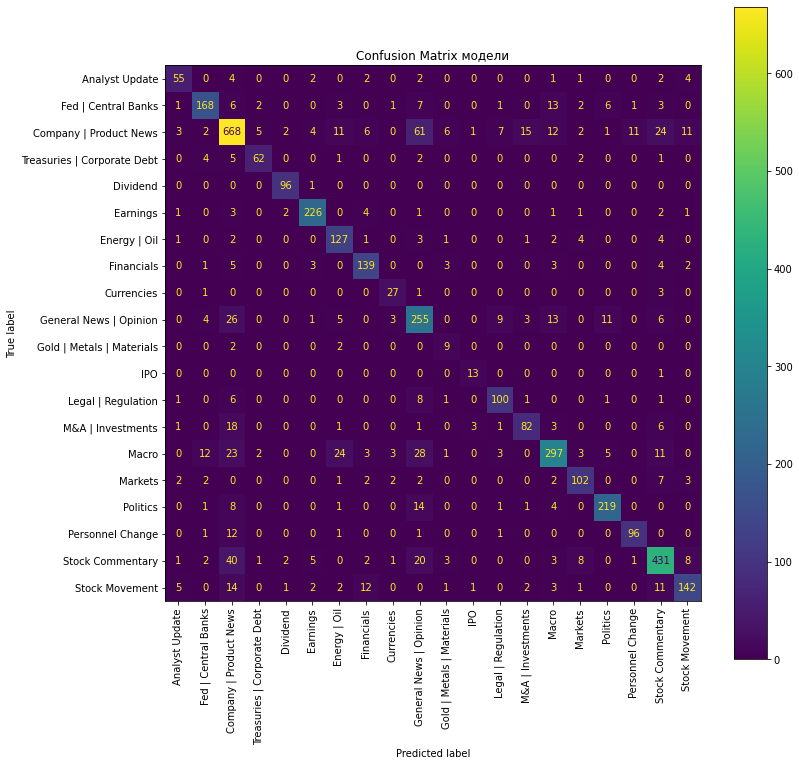

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cmatrix = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(12, 9))
cm = ConfusionMatrixDisplay(cmatrix, display_labels=list(topics.values()))
cm.plot(xticks_rotation="vertical").figure_.set_size_inches(12, 12)
plt.title("Confusion Matrix модели")

Можно заметить, что модель неплохо справляется с поставленной задачей. У классов, где представлено больше 100 обьектов, F1 метрика больше 0.75. Есть также довольно размытый класс General News, где 60 из 336 текстов классифицировались как новости компаний, но он хорошо подходит под тексты, которые однозначно нельзя классифицировать под другие темы. Хуже всего предсказываются тексты с драгоценными металами. Также новости о инвестициях тесно переплетаются с новостями о компаниях, поэтому качество немного ниже остальных классов (0.74). Но в целом модель показывает среднюю точность 80% и подходит под наши критерии

## ИТОГИ

Я поставил перед собой задачу разработать модель машинного обучения, которая относила бы заметки на финансовую тему к определенным подтемам. Для этого выбрал датасет  с твитами на финансовую тему, размеченный на 20 топиков. Затем я использовал векторизацию текстов на основе частотных методов с различной длиной вектора представления и на них обучал модели классификации - SVM и Random Forest. Для получения лучшей модели я перебрал различные наборы гиперпараметров и с помощью кросс-валидации выделил лучшие модели по метрикам качества:

SVM классификатор с гиперпараметрами C = 5, с дополнительными весами к обьектам и линейным ядром. В качетсве входных данных используется TfIdf размером 5000.

Полученную модель и векторайзер я сохранил в виде файла и написал класс (tweet_classifier.py) для дальнейшего использования моей модели в приложении.